# Exploration of 3D Kepler dynamics with a Neural network

(by Sean Cowan)

This notebook investigates the 3D Kepler ODE system (in spherical coordinates defined with azimuth ($\phi$) and colatitude ($\theta$)). In particular, we look at adding a perturbative acceleration in the form of a neural network. The equations are

$$
\begin{cases}
\dot{\rho} = \dot{\rho} \\[1mm]
\dot{\phi} = \dot{\theta} \\[1mm]
\dot{\theta} = \dot{\phi} \\[1mm]
\ddot{\rho} = -\frac{1}{\rho^2} + \rho \, \dot{\theta}^{2} + \rho \, \dot{\phi}^{2} \sin^{2}(\theta) \\[1mm]
% \ddot{\phi} = -\frac{2 \, \dot{\rho} \, \dot{\theta}}{\rho} - \frac{\dot{\phi}^{2} \, \sin(2\theta)}{2} \\[1mm]
% \ddot{\theta} = \frac{2 \, \dot{\phi} \, (\dot{\theta} \, \rho \, \tan(\theta) - \dot{\rho})}{\rho}
\ddot{\phi} = -2  \, \dot{\phi}  \, \frac{\rho \,  \dot{\theta} \frac{\cos(\theta)}{sin(\theta)} + \dot{\rho}}{\rho}) \\[1mm]
\ddot{\theta} = \dot{\phi}^2 \, \frac{\sin(2 \, \theta)}{2} - \frac{2 \, \dot{\rho} \,  \dot{\theta}}{\rho}
\end{cases}
$$

which describes, in non dimensional units, the Keplerian motion of a mass point object around some primary body with a perturbation. Keep in mind that since $\theta$ is the colatitude, it spans from $[0, \pi]$, which has a singularity at $\theta=0$, because then one would be dividing by zero in the fifth equation.

## Importing stuff

In [1]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as col

from scipy.integrate import solve_ivp

from pyaudi import gdual_double as gdual, taylor_model, int_d, sin, cos, tan
from plotting_functions import plot_n_to_3_solution_enclosure, sample_on_square_boundary

%matplotlib widget

## Define Neural Network stuff

We define weights and biases congruent with a list (e.g. [4, 10, 2]) defining the size of the network, which is then used in ml_predict to produce an output given an input. We also define the ReLu activation function for more realism (but of course it works without).

In [7]:
seed = 41+6  # Set your desired seed   

def initialize_weights(n_units, seed=seed):
    rng = np.random.Generator(np.random.MT19937(seed))
    weights = []
    
    for layer in range(1, len(n_units)):
        W_layer = np.empty((n_units[layer-1], n_units[layer]), dtype=object)
        for i in range(n_units[layer-1]):
            for j in range(n_units[layer]):
                symname = f'w_{{({layer},{j},{i})}}'
                exp_point = rng.uniform(low=-1, high=1)
                w_tm = exp_point
                W_layer[i, j] = w_tm
        weights.append(W_layer)
    
    return weights

def initialize_biases(n_units):
    biases = []
    
    for layer in range(1, len(n_units)):
        b_layer = np.empty((1, n_units[layer]), dtype=object)
        for j in range(n_units[layer]):
            symname = f'b_{{({layer},{j})}}'
            exp_point = 1
            b_tm = exp_point
            b_layer[0, j] = b_tm
        biases.append(b_layer)
    
    return biases

def ReLu(x):
    if isinstance(x, np.ndarray) and isinstance(x[0, 0], taylor_model):
        old_shape = x.shape
        x = x.reshape(-1, 1)
        for it, t in enumerate(x[:, 0]):
            if t.tpol.constant_cf > 0:
                pass
            else:
                x[it, 0] = 0
        return x.reshape(old_shape)
    elif isinstance(x, np.ndarray) and isinstance(x[0, 0], float):
        return np.where(x > 0, x, 0)
    elif isinstance(x, taylor_model):
        return x if x.tpol.constant_cf > 0 else 0
    elif isinstance(x, float):
        if x > 0:
            return x
        else:
            return 0
    else:
        raise RuntimeError(f"The input {x} of type {type(x)} is not valid.")

def ml_predict(x_in, W, b):
    layer_output = x_in
    for W_layer, b_layer in zip(W, b):
        layer_output = ReLu(layer_output @ W_layer + b_layer)
        # layer_output = layer_output @ W_layer
    return layer_output

## Integration function

In [8]:
def rk4_t(f, t0, y0, th):
    t = th
    timesteps = [(th[i + 1] - th[i]).item() for i in range(len(th) - 1)]
    y = np.array([[type(y0[0])] * np.size(y0)] * (len(t)))
    y[0] = y0
    for n in range(len(t) - 1):
        h = timesteps[n]
        xi1 = y[n]
        f1 = f(t[n], xi1)
        xi2 = y[n] + (h / 2.0) * f1
        f2 = f(t[n], xi2)
        xi3 = y[n] + (h / 2.0) * f2
        f3 = f(t[n], xi3)
        xi4 = y[n] + h * f3
        f4 = f(t[n], xi4)
        y[n + 1] = y[n] + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    return y

minimum_network = [6, 1, 3]
default_weights = initialize_weights(minimum_network)                
default_biases = initialize_biases(minimum_network)  

def rk4_t_nn(f, t0, y0, th, f_args=(default_weights, default_biases, 1e-5)):
    t = th
    timesteps = [(th[i + 1] - th[i]).item() for i in range(len(th) - 1)]
    y = np.array([[type(y0[0])] * np.size(y0)] * (len(t)))
    y[0] = y0
    for n in range(len(t) - 1):
        h = timesteps[n]
        xi1 = y[n]
        f1 = f(t[n], xi1, *f_args)
        xi2 = y[n] + (h / 2.0) * f1
        f2 = f(t[n], xi2, *f_args)
        xi3 = y[n] + (h / 2.0) * f2
        f3 = f(t[n], xi3, *f_args)
        xi4 = y[n] + h * f3
        f4 = f(t[n], xi4, *f_args)
        y[n + 1] = y[n] + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)
    return y

## Define problem

In [9]:
def eom_kep_polar_3d(t, y, mu = 1):
    return np.array([
        y[3],
        y[4],
        y[5],
        -mu/y[0]**2 + y[0]*y[4]**2*sin(y[2])**2 + y[0]*y[5]**2,
        -2*y[4]*(y[0] * y[5] * cos(y[2]) / sin(y[2]) + y[3]) / y[0],
        y[4]**2 * sin(2 * y[2]) / 2 - 2 * y[3] * y[5] / y[0]
    ])

def eom_kep_polar_3d_thrust(t, y, weights=default_weights, biases=default_biases, max_thrust=1e-5, mu = 1):
    u = max_thrust * ml_predict(y.reshape(1, -1), weights, biases).reshape(-1)
    return np.array([
        y[3],
        y[4],
        y[5],
        -mu/y[0]**2 + y[0]*y[4]**2*sin(y[2])**2 + y[0]*y[5]**2 + u[0],
        -2*y[4]*(y[0] * y[5] * cos(y[2]) / sin(y[2])  + y[3]) / y[0] + u[1],
        y[4]**2 * sin(2 * y[2]) / 2 - 2 * y[3] * y[5] / y[0] + u[2]
    ])

# Order of Taylor series
order = 2
# Tolerance
tol=1e-10
# Neural network size
n_units = [6, 32, 32, 32, 3]
# Maximum thrust acceleration
max_thrust = 1e-3
# Number of orbits to propagate with random acceleration
n_samples = 4
# Size of valid domain for Taylor model
domain_size = 0.005 

# The initial conditions
ic = [1.0, 0.0, np.pi / 2, 0.1, 1.0, 0.1]
initial_time = 0.0
final_time = 5

## Numerical propagation

In [10]:
y_num_viz = solve_ivp(
    eom_kep_polar_3d, (initial_time, final_time), ic, method="RK45", rtol=1e-13, atol=1e-13
)

## Taylor model propagation

Next, we propagate the Taylor models for a number of samples with randomised neural network weights and biases.

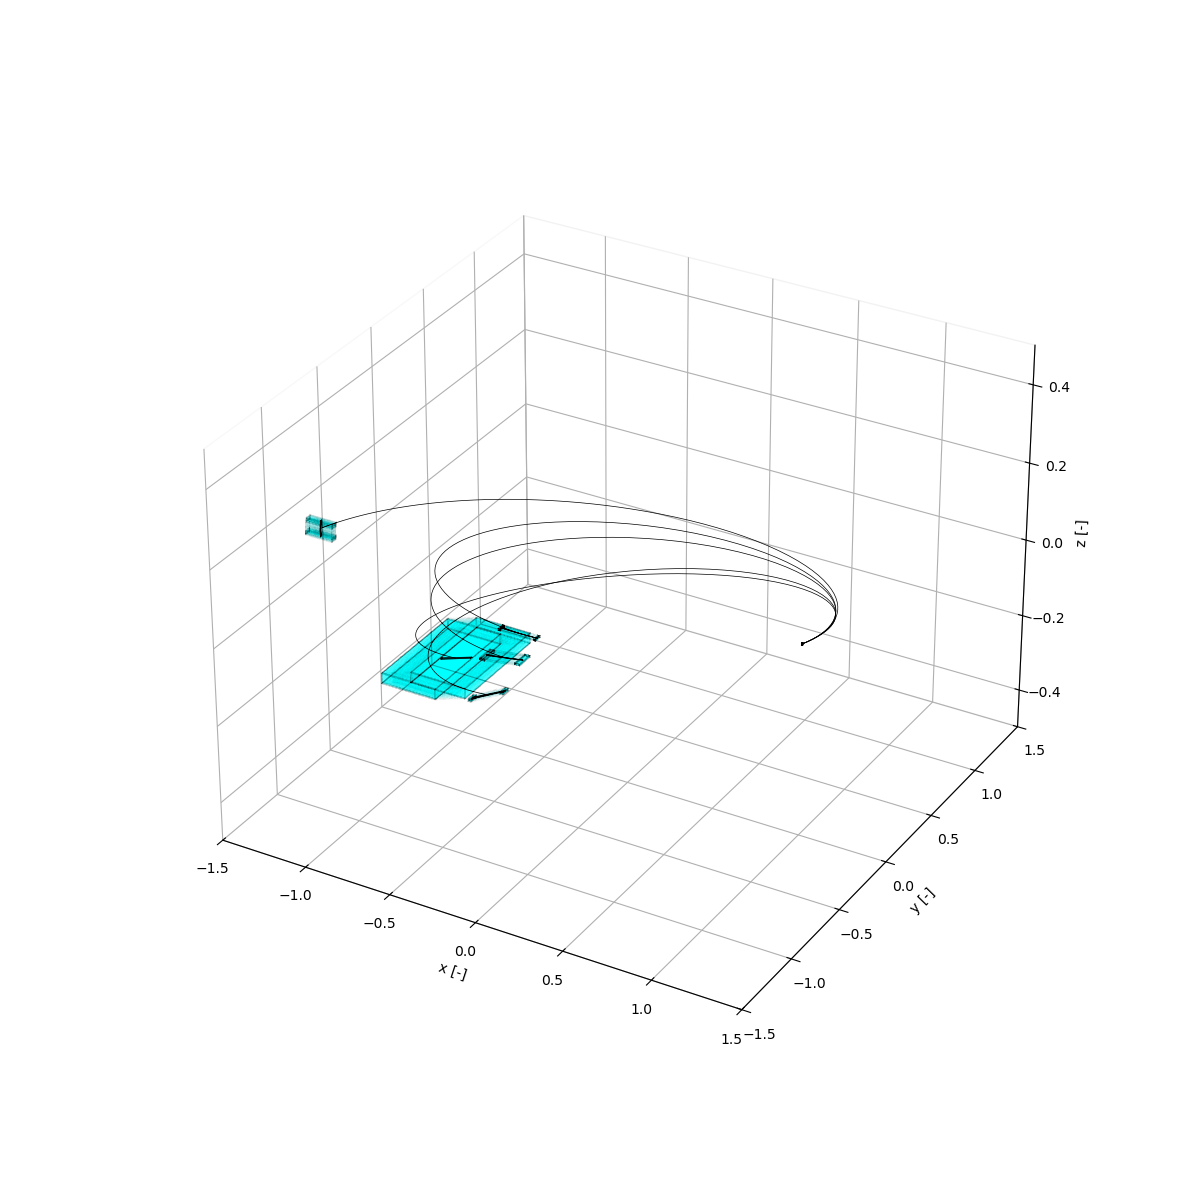

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

y_num = solve_ivp(
    eom_kep_polar_3d, (initial_time, final_time), ic, method="RK45", rtol=tol, atol=tol
)

weights_list = []
biases_list = []
tm_list = []
for it in range(n_samples+1):

    weights = initialize_weights(n_units, seed+it+1)                
    weights_list.append(weights)
    biases = initialize_biases(n_units)            
    biases_list.append(biases)

    symbols = ["r", "phi", "theta", "vr", "vphi", "vtheta"]
    ic_g = [
        gdual(ic[0], symbols[0], order),
        gdual(ic[1], symbols[1], order),
        gdual(ic[2], symbols[2], order),
        gdual(ic[3], symbols[3], order),
        gdual(ic[4], symbols[4], order),
        gdual(ic[5], symbols[5], order),
    ]
    ic_tm = [
        taylor_model(
            ic_g[i],
            int_d(0.0, 0.0),
            {symbols[i]: ic[i]},
            {symbols[i]: int_d(ic[i] - domain_size / 2, ic[i] + domain_size / 2)},
        )
        for i in range(6)
    ]

    # Only propagate rho, theta, phi as Taylor models.
    ic_tm[3] = ic[3]
    ic_tm[4] = ic[4]
    ic_tm[5] = ic[5]

    # We call the numerical integrator, this time it will compute on Taylor models
    if it == 0:
        y_tm = rk4_t(eom_kep_polar_3d, initial_time, ic_tm, y_num.t)
    else:
        y_tm = rk4_t_nn(eom_kep_polar_3d_thrust, initial_time, ic_tm, y_num.t, (weights, biases,
                                                                          max_thrust))
    tm_list.append(y_tm)
    nom_x1 = []
    nom_x2 = []
    nom_x3 = []
    for it2, y_step in enumerate(y_tm):

        r_step, phi_step, theta_step, vr_step, vphi_step, vtheta_step = y_step
        x_step = r_step * sin(theta_step) * cos(phi_step)
        y_step = r_step * sin(theta_step) * sin(phi_step)
        z_step = r_step * cos(theta_step)
        x1_tm = x_step
        x2_tm = y_step
        x3_tm = z_step

        nom_x1.append(x1_tm.tpol.constant_cf)
        nom_x2.append(x2_tm.tpol.constant_cf)
        nom_x3.append(x3_tm.tpol.constant_cf)

        if it2 == len(y_tm) - 1 or it2 == 0:
            ax = plot_n_to_3_solution_enclosure(x1_tm, x2_tm, x3_tm, ax=ax, color="k", resolution=20, plot_remainder_bound=True)

    ax.plot(nom_x1, nom_x2, nom_x3, c='k', linewidth=0.5)

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-0.5, 0.5])
ax.set_xlabel("x [-]")
ax.set_ylabel("y [-]")
ax.set_zlabel("z [-]")
# ax.grid()

# Make background white
ax.xaxis.pane.set_facecolor('white')
ax.yaxis.pane.set_facecolor('white')
ax.zaxis.pane.set_facecolor('white')

# Optionally remove the grid lines too
# ax.grid(False)